In [449]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import scipy as sc
import scipy.signal # for savgol filter
from pygam import LinearGAM # for gam models
from pygam.utils import generate_X_grid

%matplotlib inline


In [450]:
#import ridership info for the  L and import info about the L stops
Lrides = pd.read_csv("CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")

Linfo = pd.read_csv("CTA_-_System_Information_-_List_of__L__Stops.csv")
Linfo = Linfo.iloc[:,3:].drop_duplicates().reset_index(drop=True)

# merge the dataframe together
L_df = pd.merge(Lrides, Linfo, left_on= 'station_id', right_on = 'MAP_ID', how='left')

#convert date to datetype object
L_df['date'] = pd.to_datetime(L_df['date'])
L_df.tail()
print(len(L_df['stationname'].unique()))

148


Now we have a dataframe of daily rides for every L station in Chicago, and some descriptive information about those stations, such as what line they cover. There are 148 stations. Let's start by aggregating to the day and seeing the pattern of ridership for all stations.

In [660]:
L_df = pd.merge(Lrides, Linfo, left_on= 'station_id', right_on = 'MAP_ID', how='left')
L_df.head()

,station_id,stationname,date,daytype,rides,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,40010,Austin-Forest Park,01/01/2001,U,290,Austin,Austin (Blue Line),40010.0,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
1,40020,Harlem-Lake,01/01/2001,U,633,Harlem/Lake,Harlem/Lake (Green Line),40020.0,True,False,False,True,False,False,False,False,False,False,"(41.886848, -87.803176)"
2,40030,Pulaski-Lake,01/01/2001,U,483,Pulaski,Pulaski (Green Line),40030.0,True,False,False,True,False,False,False,False,False,False,"(41.885412, -87.725404)"
3,40040,Quincy/Wells,01/01/2001,U,374,Quincy/Wells,"Quincy/Wells (Brown, Orange, Purple & Pink Lines)",40040.0,False,False,False,False,False,False,True,False,True,True,"(41.878723, -87.63374)"
4,40040,Quincy/Wells,01/01/2001,U,374,Quincy/Wells,"Quincy/Wells (Brown, Orange, Purple & Pink Lines)",40040.0,False,False,False,False,True,False,False,False,False,False,"(41.878723, -87.63374)"


In [451]:
# making a copy of data frame so can always start back at square one without having to reload/clean data
L_copy = L_df.copy()
by_date = L_copy.groupby('date').aggregate(sum)[['rides']]
by_date.head()

,rides
date,
2001-01-01,119015
2001-01-02,501436
2001-01-03,536874
2001-01-04,550439
2001-01-05,556109


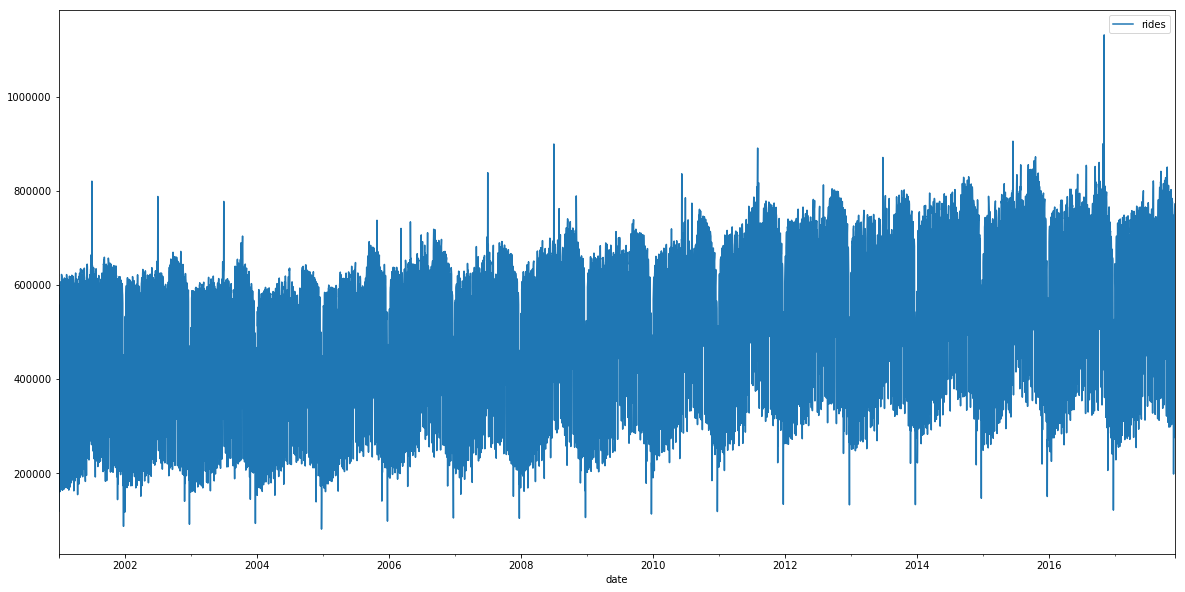

In [452]:
by_date.plot(figsize= (20,10))


Looking at the daily ridership, there's cleary some seasonal stuff happening, but the data is much too dense. Let's first look at a smaller time window, then resample (aggregate) to the weekly level to better see what's going on.

(15340, 17532)

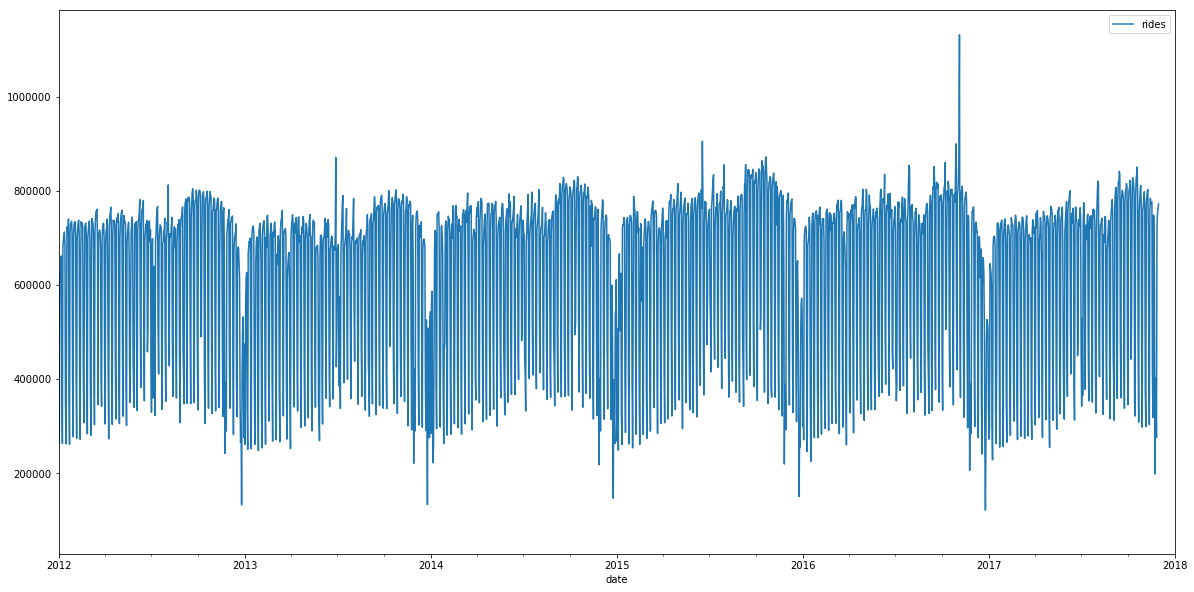

In [453]:
by_date.plot(figsize= (20,10))
plt.xlim('2012-01-01','2018-01-01')

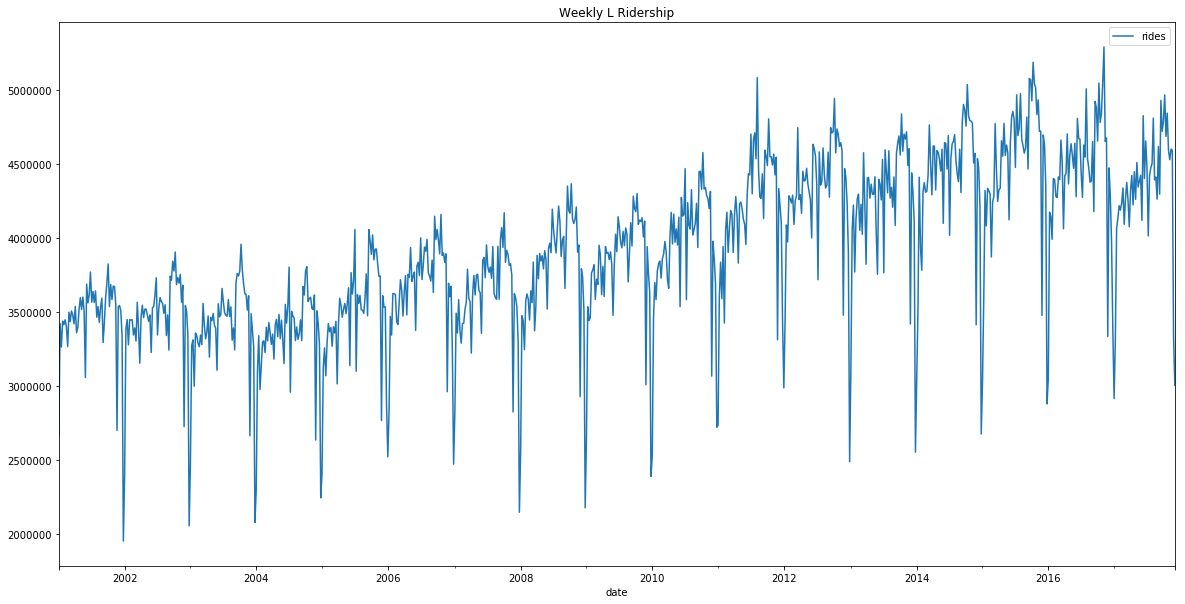

In [454]:
weekly = by_date.resample('W').sum()
weekly.plot( figsize=(20,10))
plt.title("Weekly L Ridership")

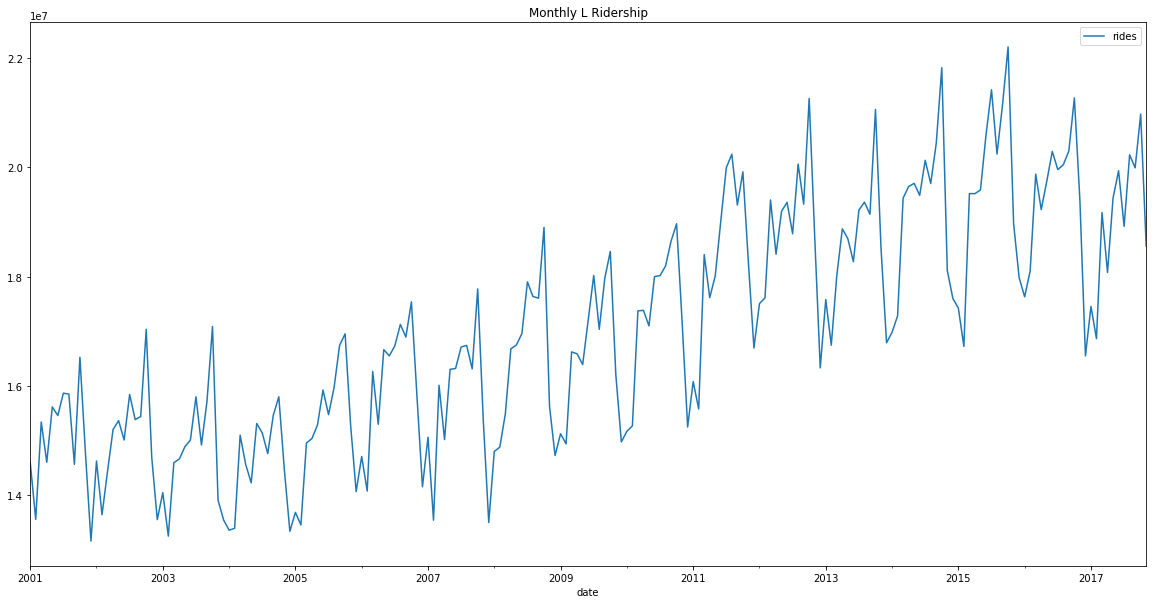

In [455]:
monthly = by_date.resample('M').sum()
monthly.plot( figsize=(20,10))
plt.title("Monthly L Ridership")

There's clearly a seasonal component. If we dig deeper at the distribution of ridership across Months and Weekdays,
we see that on average, October has the highest ridership, and winter months, especially December, has lower rides.

During the Week, ridership is pretty steady, except Monday, which has lower ridership. And the weekend, Sunday especially, rides drop off significantly.

It's a little odd that Day of Week rides on average are greater than monthly rides. Perhaps this is an indication of the volatility of rides throughout the week, so it is subject to more outliers that could pull the average up.

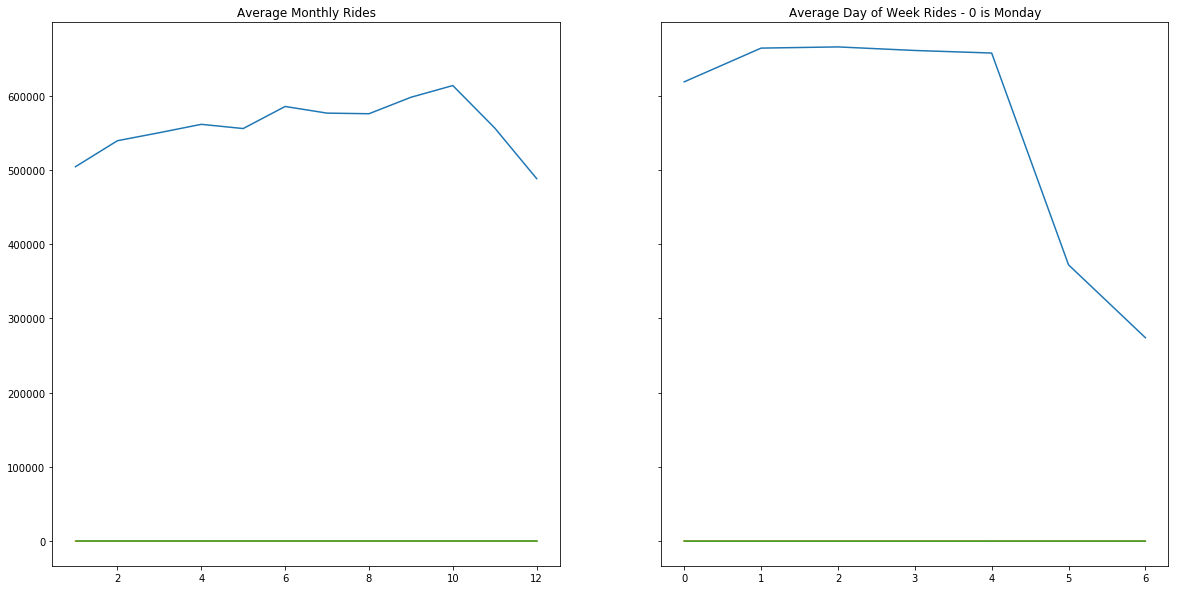

In [456]:
by_date['month'] = by_date.index.month
by_date['weekday'] = by_date.index.dayofweek

by_weekday = by_date.groupby(by_date.index.dayofweek).mean()
#by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
#by_weekday.plot()

by_month = by_date.groupby(by_date.index.month).mean()
#by_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#by_month.plot()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))
ax1.plot(by_month)
ax1.set_title('Average Monthly Rides')
ax2.plot(by_weekday)
ax2.set_title('Average Day of Week Rides - 0 is Monday')


We should now look into understanding the different parts of the series -- the trend and the different seasonalities (it seems possible that there are weekly and yearly seasonalities)


## Trend

We can estimate trend several ways: 
-  moving average, which would be a specific type of kernel regression (kernel with equal weights)
-  linear regression, assuming a polynomial in t
-  Non-parametric approaches
    -  Local Polynomial Regression (LOESS)
    -  Regression splines (GAM)

In [457]:
#create a training and test set
train = by_date[by_date.index < '2017-06-01'].copy()
test = by_date[by_date.index >= '2017-06-01'].copy()


In [537]:
y

array([119015, 501436, 536874, ..., 314499, 713503, 735754])

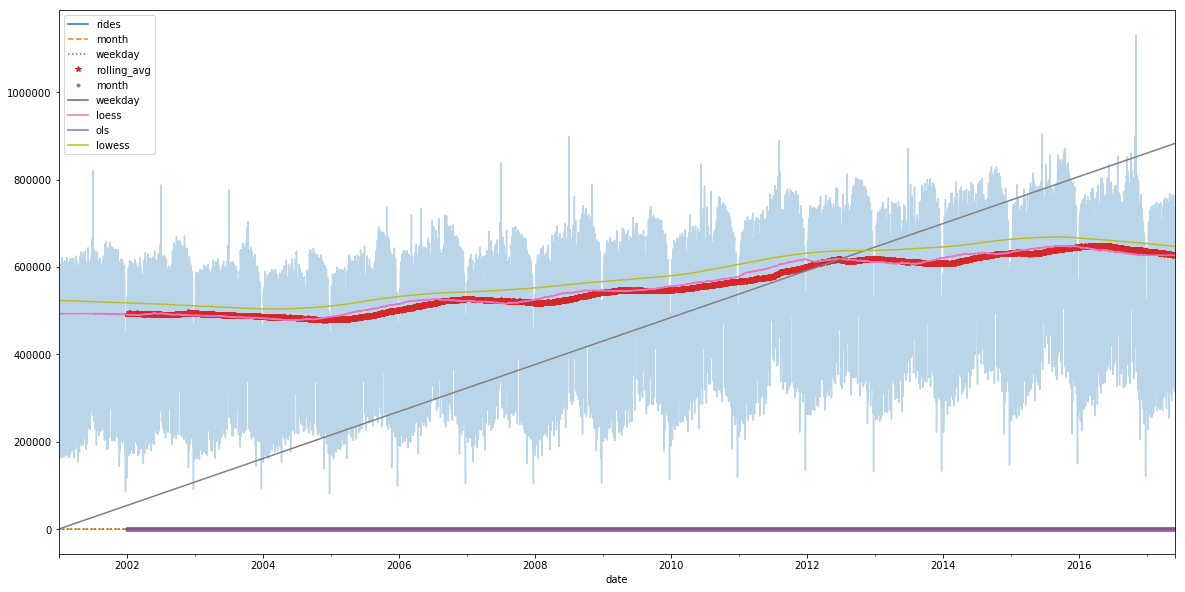

In [534]:
#rolling average
rolling = train.rolling(365, center=False).mean()
rolling = rolling.rename(columns ={'rides' : 'rolling_avg'})

#local polynomial fitting
#https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
loess = pd.DataFrame(sc.signal.savgol_filter(train['rides'], window_length=365, polyorder=0), index = train.index)
loess = loess.rename(columns ={0 : 'loess'})
# parametric regression



# ordinary least squares regression
x = np.asarray(list(range(1,len(train['rides']) +1)))
x2 = (x )#** 2.0) #2nd order polynomial
X = pd.DataFrame({'x1' : x, 'x2' : x2})
#X = sm.add_constant(X)
y = train['rides'].values

lmfit = sm.OLS(y, X).fit()

ols = pd.DataFrame(lmfit.fittedvalues)
ols.index = train.index
ols = ols.rename(columns = {0 : 'ols'})

#lowess
lowess = sm.nonparametric.lowess(y, x, frac=.2)#365*2/len(train))

# unpack the lowess smoothed points to their values
lowess_x1 = list(zip(*lowess))[0]
lowess_y1 = list(zip(*lowess))[1]

lowess_y = pd.DataFrame(list(lowess_y1))
lowess_y.index = train.index
lowess_y = lowess_y.rename(columns = {0 : 'lowess'})


#put the different fitted values/estimates in one frame
data = pd.concat([train, rolling, loess, ols, lowess_y ], axis=1)

ax = data.plot(style=['-', '--', ':', '*','.'], figsize=(20,10))
ax.lines[0].set_alpha(0.3)




Above we use three methods for estimating the trend. A rolling (moving) average, local polynomial regression, and ordinary least squares with a second order polynomial. The non-parametric methods fit the data the best, although loess seems to get a big wonky at the very end of the data set. Ordinary least squares is clearly not a good method, and this makes sense as our time series data violates some of the model assumptions.

We see that there has been a slowly increasing trend in ridership over the past 15 years.

We can take a look at the ols summary below.

## Seasonality

In [459]:
import statsmodels.formula.api as smf

We can estimate seasonality using least squares regression as well by creating dummy variables for the seasonal components. Below we see the plot for monthly seasonality as well as day of week seasonality.

In [460]:
#subtract trend before we find seasonality

detrended = pd.concat([train, loess,], axis=1)

detrended['rides'] = detrended['rides'] - detrended['loess']
#detrended.pop('loess')
detrended.head()

,rides,month,weekday,loess
date,,,,
2001-01-01,-373997.572603,1,0,493012.572603
2001-01-02,8423.427397,1,1,493012.572603
2001-01-03,43861.427397,1,2,493012.572603
2001-01-04,57426.427397,1,3,493012.572603
2001-01-05,63096.427397,1,4,493012.572603


In [461]:
detrended.loc[:,'month'] = pd.Categorical(detrended.month).codes

est = smf.ols(formula='rides ~ C(month)', data=detrended).fit()
est.summary()

/anaconda/lib/python3.6/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/anaconda/lib/python3.6/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 10 Feb 2018   Prob (F-statistic):           3.61e-44
Time:                        16:57:16   Log-Likelihood:                -80577.
No. Observations:                5995   AIC:                         1.612e+05
Df Residuals:                    5983   BIC:                         1.613e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.101e+04   7252.612     -7.034      0.000   -6.52e+04   -3.68e+04
C(month)[T.1]   3.419e+04   1.05e+04      3.255      0.001    1.36e+04    5.48e+04
C(month)[T.2]    4.44e+04   1.03e+04      4.329      0.000    2.43e+04    6.45e+04
C(month)[T.3]   5.486e+04   1.03e+04      5.304      0.000    3.46e+04    7.51e+04
C(month)[T.4]   4.822e+04   1.03e+04      4.701      0.000    2.81e+04    6.83e+04
C(month)[T.5]   7.667e+04   1.05e+04      7.298      0.000    5.61e+04    9.73e+04
C(month)[T.6]   7.004e+04   1.04e+04      6.725      0.000    4.96e+04    9.05e+04
C(month)[T.7]   6.597e+04   1.04e+04      6.334      0.000    4.56e+04    8.64e+04
C(month)[T.8]   8.806e+04   1.05e+04      8.383      0.000    6.75e+04    1.09e+05
C(month)[T.9]   1.036e+05   1.04e+04      9.947      0.000    8.32e+04    1.24e+05
C(month)[T.10]  4.577e+04   1.05e+04      4.357      0.000    2.52e+04    6.64e+04
C(month)[T.11] -1.928e+04   1.04e+04     -1.851      0.064   -3.97e+04    1137.061
==============================================================================
Omnibus:                     1335.664   Durbin-Watson:                   1.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              922.421
Skew:                          -0.851   Prob(JB):                    5.00e-201
Kurtosis:                       2.109   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [462]:
detrended.loc[:,'weekday'] = pd.Categorical(detrended.weekday).codes #making weekday a categorical variable

est2 = smf.ols(formula='rides ~ C(weekday)', data=detrended).fit() #C makes weekday encoded to k-1 dummy variables
est2.summary()

/anaconda/lib/python3.6/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/anaconda/lib/python3.6/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     3953.
Date:                Sat, 10 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:57:16   Log-Likelihood:                -75894.
No. Observations:                5995   AIC:                         1.518e+05
Df Residuals:                    5988   BIC:                         1.518e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.886e+04   2602.990     22.613      0.000    5.38e+04     6.4e+04
C(weekday)[T.1]  4.568e+04   3681.184     12.408      0.000    3.85e+04    5.29e+04
C(weekday)[T.2]   4.69e+04   3681.184     12.741      0.000    3.97e+04    5.41e+04
C(weekday)[T.3]  4.198e+04   3682.259     11.401      0.000    3.48e+04    4.92e+04
C(weekday)[T.4]  3.876e+04   3682.259     10.527      0.000    3.15e+04     4.6e+04
C(weekday)[T.5]  -2.45e+05   3682.259    -66.530      0.000   -2.52e+05   -2.38e+05
C(weekday)[T.6] -3.434e+05   3682.259    -93.249      0.000   -3.51e+05   -3.36e+05
==============================================================================
Omnibus:                     4157.899   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72324.090
Skew:                          -3.138   Prob(JB):                         0.00
Kurtosis:                      18.816   Cond. No.                         7.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

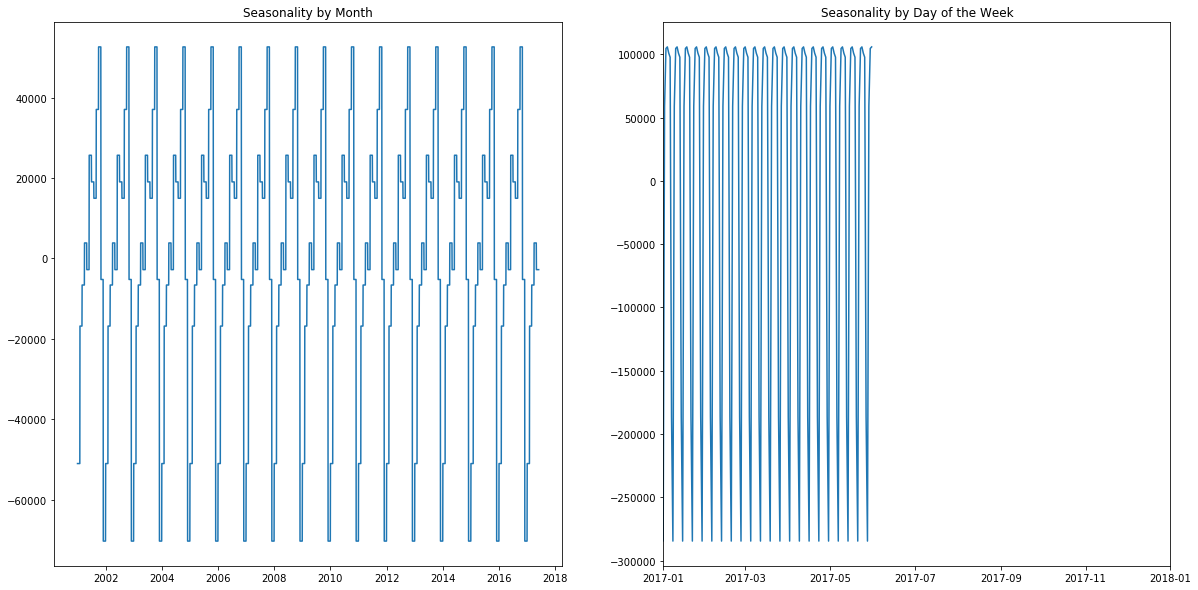

In [463]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,10))
ax1.plot(est.fittedvalues)
ax1.set_title('Seasonality by Month')
ax2.plot(est2.fittedvalues)#, xlim=('2017-01-01', '2018-01-01'))
plt.xlim('2017-01-01', '2018-01-01')
ax2.set_title('Seasonality by Day of the Week')


Below we combine both day of week and monthly variables as categorical variable to see the seasonal effects of both.
These two variable make up nearly 84% of the variability in the data.

/anaconda/lib/python3.6/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/anaconda/lib/python3.6/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


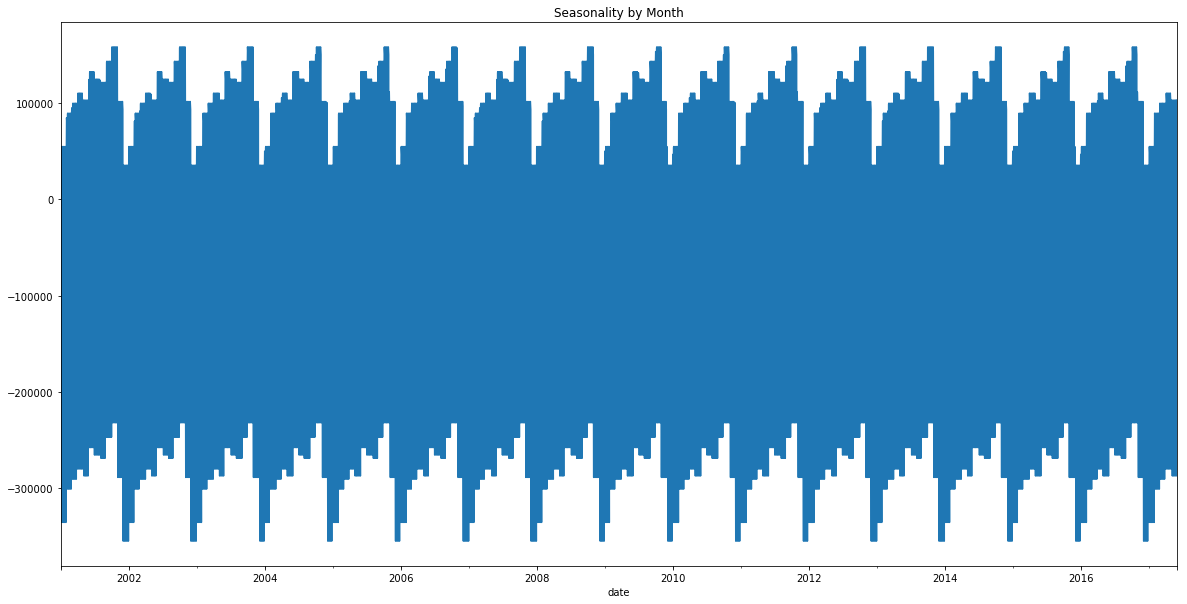

In [464]:
est3 = smf.ols(formula='rides ~ C(weekday) + C(month)', data=detrended).fit() #C makes weekday encoded to k-1 dummy variables
est3.fittedvalues.plot(figsize = (20,10))
plt.title("Seasonality by Month")

In [465]:
est3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sat, 10 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:57:17   Log-Likelihood:                -75254.
No. Observations:                5995   AIC:                         1.505e+05
Df Residuals:                    5977   BIC:                         1.507e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7939.3215   3691.364      2.151      0.032     702.916    1.52e+04
C(weekday)[T.1]  4.571e+04   3311.949     13.801      0.000    3.92e+04    5.22e+04
C(weekday)[T.2]  4.678e+04   3311.933     14.125      0.000    4.03e+04    5.33e+04
C(weekday)[T.3]  4.198e+04   3312.909     12.672      0.000    3.55e+04    4.85e+04
C(weekday)[T.4]  3.864e+04   3312.910     11.663      0.000    3.21e+04    4.51e+04
C(weekday)[T.5]  -2.45e+05   3312.902    -73.961      0.000   -2.52e+05   -2.39e+05
C(weekday)[T.6] -3.435e+05   3312.906   -103.682      0.000    -3.5e+05   -3.37e+05
C(month)[T.1]    3.462e+04   4325.598      8.004      0.000    2.61e+04    4.31e+04
C(month)[T.2]    4.495e+04   4223.438     10.643      0.000    3.67e+04    5.32e+04
C(month)[T.3]    5.545e+04   4258.492     13.020      0.000    4.71e+04    6.38e+04
C(month)[T.4]    4.822e+04   4223.433     11.417      0.000    3.99e+04    5.65e+04
C(month)[T.5]    7.769e+04   4325.598     17.961      0.000    6.92e+04    8.62e+04
C(month)[T.6]    6.997e+04   4288.921     16.313      0.000    6.16e+04    7.84e+04
C(month)[T.7]    6.658e+04   4288.936     15.524      0.000    5.82e+04     7.5e+04
C(month)[T.8]    8.849e+04   4325.588     20.457      0.000       8e+04     9.7e+04
C(month)[T.9]    1.034e+05   4288.931     24.114      0.000     9.5e+04    1.12e+05
C(month)[T.10]   4.672e+04   4325.593     10.801      0.000    3.82e+04    5.52e+04
C(month)[T.11]  -1.938e+04   4288.926     -4.520      0.000   -2.78e+04    -1.1e+04
==============================================================================
Omnibus:                     4521.232   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102634.844
Skew:                          -3.438   Prob(JB):                         0.00
Kurtosis:                      22.068   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [466]:
#put seasonally fitted values in data frame
seas = pd.DataFrame(est3.fittedvalues)
seas = seas.rename(columns = { 0 : 'season'})
seas.head()

#combine that df with detrended
deseas = pd.concat([detrended, seas], axis=1)


deseas['rides'] = deseas['rides'] - deseas['season']
#detrended.pop('loess')
deseas.head()

,rides,month,weekday,loess,season
date,,,,,
2001-01-01,-381936.894090,0,0,493012.572603,7939.321487
2001-01-02,-45224.002365,0,1,493012.572603,53647.429762
2001-01-03,-10858.641454,0,2,493012.572603,54720.068851
2001-01-04,7506.339469,0,3,493012.572603,49920.087928
2001-01-05,16517.011932,0,4,493012.572603,46579.415465


In [467]:
#fit trend using gam
# remove trend and seasonality and see what the shape of the remainder is
#stl decomp out of the box

#make a forecast

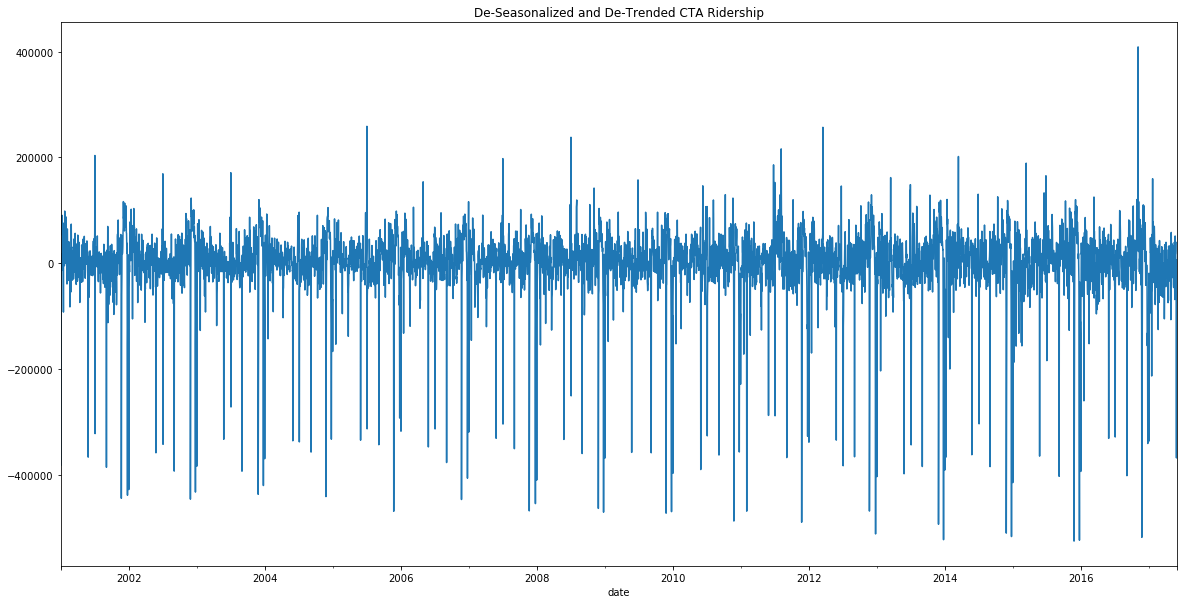

In [569]:
deseas['rides'].plot(figsize=(20,10))
plt.title("De-Seasonalized and De-Trended CTA Ridership")


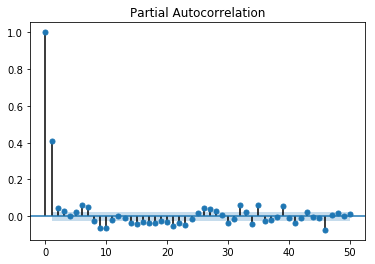

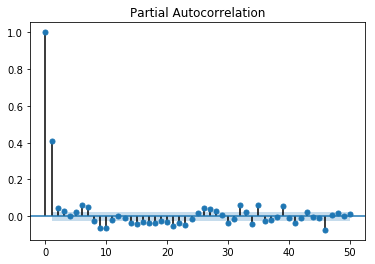

In [572]:
plot_pacf(deseas['rides'], lags=50)